# Load dataset

In [1]:
# Load the datasets
import pandas as pd

# Load both H1 (Resort Hotel) and H2 (City Hotel)
data_h1 = pd.read_csv('dataset/H1.csv')
data_h1['Hotel'] = 'H1'
data_h2 = pd.read_csv('dataset/H2.csv')
data_h2['Hotel'] = 'H2'

# Concatenate datasets (Resort and City hotel)
data_combined = pd.concat([data_h1, data_h2], ignore_index=True)

# Initial data inspection
data_combined.head()
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13 

# Cleaning, filling missing values, drop values

In [2]:
data_cleaned = data_combined.copy()

# Convert categorical month to numerical 1-12
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']
data_cleaned['ArrivalDateMonth'] = data_cleaned['ArrivalDateMonth'].apply(lambda x: months.index(x) + 1)

# 'Children' missing values can be filled with 0
data_cleaned['Children'] = data_cleaned['Children'].fillna(0)

# Replace SC with Undefined in Meal column
data_cleaned['Meal'] = data_cleaned['Meal'].str.strip()
data_cleaned['Meal'] = data_cleaned['Meal'].replace('SC', 'Undefined')

# deletion on rows that have missing distribution_channel, market_segment feature values.
data_cleaned = data_cleaned.dropna(subset=['DistributionChannel', 'MarketSegment'])
data_cleaned = data_cleaned[data_cleaned['DistributionChannel'] != 'Undefined']

# Clean data to remove any leading/trailing spaces
data_cleaned['ReservedRoomType'] = data_cleaned['ReservedRoomType'].str.strip()
data_cleaned['DistributionChannel'] = data_cleaned['DistributionChannel'].str.strip()
data_cleaned['DepositType'] = data_cleaned['DepositType'].str.strip()

data_cleaned = data_cleaned.drop(columns=['Country', 
                                          'ArrivalDateWeekNumber', 
                                          'AssignedRoomType', 
                                          'RequiredCarParkingSpaces'])

# Some rows contain entries with 0 adults, 0 children and 0 babies. 
zero_guests = list(data_cleaned.loc[data_cleaned["Adults"]
                   + data_cleaned["Children"]
                   + data_cleaned["Babies"]==0].index)
data_cleaned = data_cleaned.drop(data_cleaned.index[zero_guests])

# Inspect the cleaned data
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119205 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119205 non-null  int64  
 1   LeadTime                     119205 non-null  int64  
 2   ArrivalDateYear              119205 non-null  int64  
 3   ArrivalDateMonth             119205 non-null  int64  
 4   ArrivalDateDayOfMonth        119205 non-null  int64  
 5   StaysInWeekendNights         119205 non-null  int64  
 6   StaysInWeekNights            119205 non-null  int64  
 7   Adults                       119205 non-null  int64  
 8   Children                     119205 non-null  float64
 9   Babies                       119205 non-null  int64  
 10  Meal                         119205 non-null  object 
 11  MarketSegment                119205 non-null  object 
 12  DistributionChannel          119205 non-null  object 
 13  IsRe

# "Convenient" Data Splitting

In [3]:
from sklearn.model_selection import train_test_split

def convenient_split_data(data):
    """
    Perform stratified split on the data

    Parameters
    ----------
    data : pd.DataFrame
        The data to split

    Returns
    -------
    X_train : pd.DataFrame
        The training data
    X_test : pd.DataFrame   
        The testing data
    y_train : pd.Series
        The training target
    y_test : pd.Series
        The testing target
    """
    
    data = data.sort_values(by=['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth'])
    
    X = data.drop(columns=['IsCanceled'])
    y = data['IsCanceled']
    
    X['YearMonth'] = X['ArrivalDateYear'].astype(str) + '-' + X['ArrivalDateMonth'].astype(str)
    
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    
    # Loop over each block and perform stratified split
    for block in X['YearMonth'].unique():
        X_block = X[X['YearMonth'] == block].drop(columns=['YearMonth'])
        y_block = y[X['YearMonth'] == block]
        
        X_train_block, X_test_block, y_train_block, y_test_block = train_test_split(
            X_block, y_block, test_size=0.25, stratify=y_block, random_state=42)
        
        X_train_list.append(X_train_block)
        X_test_list.append(X_test_block)
        y_train_list.append(y_train_block)
        y_test_list.append(y_test_block)
    
    X_train = pd.concat(X_train_list)
    X_test = pd.concat(X_test_list)
    y_train = pd.concat(y_train_list)
    y_test = pd.concat(y_test_list)

    return X_train, X_test, y_train, y_test

X_convenient_train, X_convenient_test, y_convenient_train, y_convenient_test = convenient_split_data(data_cleaned)

<hr>

# Models comparison

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from estimators.Wrapper import Wrapper
from estimators.BookingFeaturesTransformer import BookingFeaturesTransformer
from estimators.preprocessor import preprocessor

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Bagging': BaggingClassifier(random_state=42),
    'Bayesian': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42)
}

# Define scoring metrics for cross_validate
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc' ]

# Perform cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista per salvare i risultati
all_results = []

# Esegui TimeSeriesSplit per ognuno dei modelli
for model_name, model in models.items():

    pipeline = Pipeline(steps=[
        ('feature_transformer', Wrapper(BookingFeaturesTransformer())),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Get cross-validated predictions
    y_pred = cross_val_predict(
        pipeline, X_convenient_train, y_convenient_train,
        cv=skf, method='predict'
    )
    
    # Get predicted probabilities for ROC AUC
    y_prob = cross_val_predict(
        pipeline, X_convenient_train, y_convenient_train,
        cv=skf, method='predict_proba'
    )[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_convenient_train, y_pred)
    precision = precision_score(y_convenient_train, y_pred)
    recall = recall_score(y_convenient_train, y_pred)
    f1 = f1_score(y_convenient_train, y_pred)
    roc_auc = roc_auc_score(y_convenient_train, y_prob)

    # Store results
    all_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
    })

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_convenient_train, y_pred)
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_convenient_train, y_prob)
    roc_auc_value = auc(fpr, tpr)

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize to make it compact

    # Plot the Confusion Matrix on the first subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix for {model_name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot the ROC curve on the second subplot
    axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
    axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve for {model_name}')
    axes[1].legend(loc="lower right")

    # Show the combined plots
    plt.tight_layout()
    plt.show()


results_df = pd.DataFrame(all_results)
results_df

KeyboardInterrupt: 

# Model results

In [5]:
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

from estimators.Wrapper import Wrapper
from estimators.BookingFeaturesTransformer import BookingFeaturesTransformer
from estimators.preprocessor import preprocessor

pipeline = Pipeline(steps=[
    ('feature_transformer', Wrapper(BookingFeaturesTransformer())),  # Feature engineering
    ('combined_preprocessor', preprocessor),                                 # Preprocessing (StandardScaler, OneHotEncoder, Logit-Odds)
    ('smote', SMOTE(random_state=42)),                              # Apply SMOTE to balance the classes
    ('model', XGBClassifier(random_state=42))                       # The current model
])

pipeline.fit(X_convenient_train, y_convenient_train)

y_pred = pipeline.predict(X_convenient_test)
y_prob = pipeline.predict_proba(X_convenient_test)[:, 1]

accuracy = accuracy_score(y_convenient_test, y_pred)
precision = precision_score(y_convenient_test, y_pred)
recall = recall_score(y_convenient_test, y_pred)
f1 = f1_score(y_convenient_test, y_pred)
roc_auc = roc_auc_score(y_convenient_test, y_pred)

# create a dataframe to store the results
results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC AUC': [roc_auc]
})
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.833607,0.797828,0.738028,0.766764,0.813956


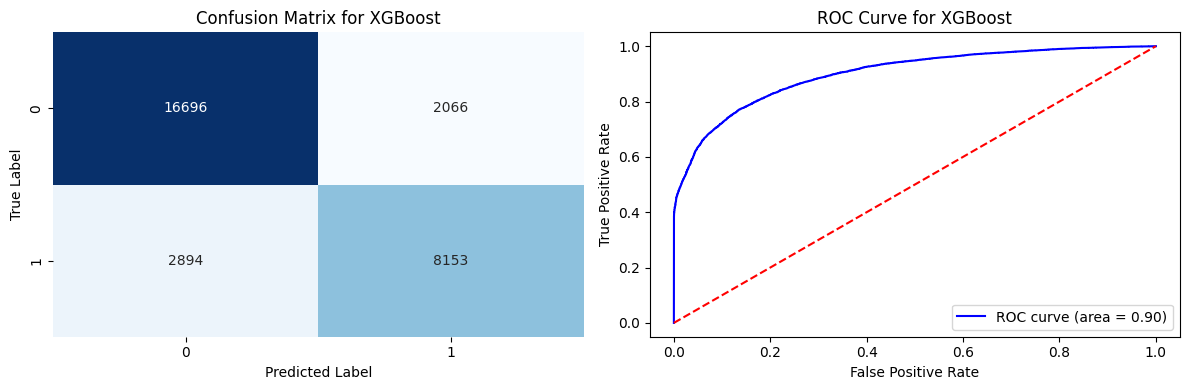

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

cm = confusion_matrix(y_convenient_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_convenient_test, y_prob)
roc_auc_value = auc(fpr, tpr)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize to make it compact

# Plot the Confusion Matrix on the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'Confusion Matrix for XGBoost')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the ROC curve on the second subplot
axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve for XGBoost')
axes[1].legend(loc="lower right")

# Show the combined plots
plt.tight_layout()
plt.show()

# Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the parameters to tune
param_grid = {
    'model__n_estimators': [100, 200, 300, 500],  
    'model__max_depth': [3, 5, 7, 9],  
    'model__learning_rate': [0.1, 0.05, 0.01, 0.005]
}

scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring,refit='recall', cv=skf, n_jobs=-1)
grid_search.fit(X_convenient_train, y_convenient_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best recall: ", grid_search.cv_results_['mean_test_recall'].max())
print("Best ROC AUC: ", grid_search.cv_results_['mean_test_roc_auc'].max())

# Fine tuned model evaluation

In [ ]:
# Let's define the model with the best parameters and rerun it
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from estimators.Wrapper import Wrapper
from estimators.BookingFeaturesTransformer import BookingFeaturesTransformer
from estimators.preprocessor import preprocessor


# Best parameters from grid search
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300
}

# Define the pipeline with the best model parameters
best_pipeline = Pipeline(steps=[
    ('feature_transformer', Wrapper(BookingFeaturesTransformer())),  # Feature engineering
    ('preprocessing', preprocessor),                                 # Preprocessing (StandardScaler, OneHotEncoder, etc.)
    ('smote', SMOTE(random_state=42)),                               # Balancing classes using SMOTE
    ('model', XGBClassifier(random_state=42, **best_params))         # Best model with tuned hyperparameters
])

# Fit the model on the training data
best_pipeline.fit(X_convenient_train, y_convenient_train)

# Predictions
y_pred = best_pipeline.predict(X_convenient_test)
y_prob = best_pipeline.predict_proba(X_convenient_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_convenient_test, y_pred)
precision = precision_score(y_convenient_test, y_pred)
recall = recall_score(y_convenient_test, y_pred)
f1 = f1_score(y_convenient_test, y_pred)
roc_auc = roc_auc_score(y_convenient_test, y_pred)

# create a dataframe to store the results
results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC AUC': [roc_auc]
})
results


In [ ]:
# Display confusion matrix
cm = confusion_matrix(y_convenient_test, y_pred)
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_convenient_test, y_prob)
roc_auc_value = auc(fpr, tpr)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize to make it compact

# Plot the Confusion Matrix on the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'Confusion Matrix for XGBoost')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the ROC curve on the second subplot
axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve for XGBoost')
axes[1].legend(loc="lower right")

# Show the combined plots
plt.tight_layout()
plt.show()


# Feature importance

In [ ]:
# Access the model and importance
model = best_pipeline.named_steps['model']
importance = model.feature_importances_

# Access the preprocessing step
preprocessor = best_pipeline.named_steps['preprocessing']

# Get numerical feature names
numerical_features_names = preprocessor.transformers_[0][2]

# Get OneHotEncoder and categorical features
ohe = preprocessor.named_transformers_['cat']
categorical_features_modified = preprocessor.transformers_[1][2]
ohe_feature_names = ohe.get_feature_names_out(categorical_features_modified)

# Get logit odds feature names
logit_odds_encoder = preprocessor.named_transformers_['logit_odds']
logit_odds_feature_names = []
for col in logit_odds_encoder.columns:
    logit_odds_feature_names.append(f'{col}_logit_odds')
    logit_odds_feature_names.append(f'{col}_prevalence')

# Combine all feature names
all_feature_names = (
    list(numerical_features_names) +
    list(ohe_feature_names) +
    logit_odds_feature_names
)

# Verify that the number of features matches
assert len(all_feature_names) == len(importance), "Feature counts do not match!"

# Create a DataFrame with feature names and importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance
})

# Sort the values by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.reset_index(drop=True, inplace=True)
feature_importance_df


# Fine tuned model evaluation after feature importance

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from estimators.LogitOddsEncoder import LogitOddsEncoder
from estimators.Wrapper import Wrapper
from estimators.BookingFeaturesTransformer import BookingFeaturesTransformer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Entire dataset columns
numerical_features = ['LiveTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'ADRThirdQuartileDeviation', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'TotalOfSpecialRequests']
categorical_features = ['DepositType', 'DistributionChannel', 'CustomerType', 'Meal', 'Hotel', 'MarketSegment', 'Agent', 'Company']

# Drop features that are not important (according to feature importance)
drop_numerical_features = ['Babies']
drop_categorical_features = ['DistributionChannel', 'MarketSegment', 'Hotel']

numerical_features = [col for col in numerical_features if col not in drop_numerical_features]
categorical_features = [col for col in categorical_features if col not in drop_categorical_features]

drop_features = drop_numerical_features + drop_categorical_features

feat_imp_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features[:-2]),
        ('logit_odds', LogitOddsEncoder(columns=['Agent', 'Company']), ['Agent', 'Company'])
    ])

# Best parameters from grid search
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300
}

# Define the pipeline with the best model parameters
feat_imp_pipeline = Pipeline(steps=[
    ('feature_transformer', Wrapper(BookingFeaturesTransformer(drop_columns=drop_features))),  # Feature engineering
    ('preprocessing', feat_imp_preprocessor),                                 # Preprocessing (StandardScaler, OneHotEncoder, etc.)
    ('smote', SMOTE(random_state=42)),                               # Balancing classes using SMOTE
    ('model', XGBClassifier(random_state=42, **best_params))         # Best model with tuned hyperparameters
])

# Fit the model on the training data
feat_imp_pipeline.fit(X_convenient_train, y_convenient_train)

# Predictions
y_pred = feat_imp_pipeline.predict(X_convenient_test)
y_prob = feat_imp_pipeline.predict_proba(X_convenient_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_convenient_test, y_pred)
precision = precision_score(y_convenient_test, y_pred)
recall = recall_score(y_convenient_test, y_pred)
f1 = f1_score(y_convenient_test, y_pred)
roc_auc = roc_auc_score(y_convenient_test, y_pred)

# create a dataframe to store the results
results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC AUC': [roc_auc]
})
results

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Display confusion matrix
cm = confusion_matrix(y_convenient_test, y_pred)
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_convenient_test, y_prob)
roc_auc_value = auc(fpr, tpr)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize to make it compact

# Plot the Confusion Matrix on the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'Confusion Matrix for XGBoost')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the ROC curve on the second subplot
axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve for XGBoost')
axes[1].legend(loc="lower right")

# Show the combined plots
plt.tight_layout()
plt.show()


<hr>

# Export model

In [13]:
import pickle

# Save the trained model as a pickle file
with open('booking_cancellations_classifier.pkl', 'wb') as model_file:
    pickle.dump(feat_imp_pipeline, model_file)